# Setting

If you want to create an environment, run the following commands step by step.

- Create a conda environment
    - conda create -n hyundai python=3.9
    - conda activate hyundai


- Install packages
    - pip install gymnasium matplotlib "gymnasium[toy-text]"

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print("numpy version", np.__version__)
print("gymnasium (gym) version", gym.__version__)
print("matplotlib version", matplotlib.__version__)

numpy version 2.0.2
gymnasium (gym) version 1.2.0
matplotlib version 3.10.0


# Environment

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

In [2]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array").unwrapped

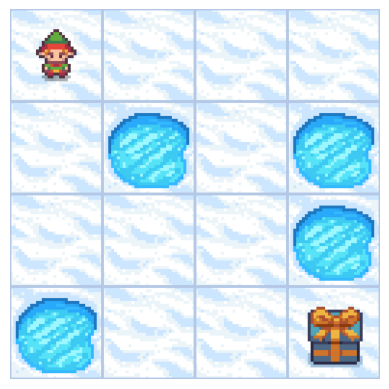

In [3]:
obs, info = env.reset(seed=1)

# Get Image
img = env.render()   # numpy array (H, W, 3)

plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
env.P[6][0]

[(0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 10, 0.0, False)]

- from state 6 and taking action 0, there is 0.33 probability transitioning to state 2, with reward 0.0, transition is non-terminal
- from state 6 and taking action 0, there is 0.33 probability transitioning to state 5, with reward 0.0, transition is terminal, MDP ends
- from state 6 and taking action 0, there is 0.33 probability transitioning to state 10, with reward 0.0, transition is non-terminal

# Problem 1 (Policy iteration)

In [5]:
def policy_evaluation(env, pi, V, gamma, theta):
    """
    Policy Evaluation: iterative policy evaluation until convergence
    """
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            val = 0
            for a, action_prob in enumerate(pi[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    #####################################
                    # Fill in the value function update #
                    val += action_prob * prob * (reward + gamma * V[next_state])
                    #####################################
            V[s] = val
            ###########################
            # Fill in the delta value #
            delta = max(delta, abs(v-V[s]))
            ###########################
        if delta < theta:
            break
    return V

In [6]:
def policy_improvement(env, V, pi, gamma):
    """
    Policy Improvement: update pi greedily wrt V
    """
    policy_stable = True
    action = np.zeros(env.observation_space.n, dtype=int)

    for s in range(env.observation_space.n):
        old_action = np.argmax(pi[s])  # best action under old policy

        # compute q(s,a) for each action
        q_vals = np.zeros(env.action_space.n)

        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[s][a]:
                ######################################
                # Fill in the q_vals function update #
                q_vals[a] += prob *(reward + gamma * V[next_state])
                ######################################

        ################################
        # Find best_action for state s #
        best_action = np.argmax(q_vals)
        ################################

        ###########################
        # update policy to greedy #
        pi[s] = np.eye(env.action_space.n)[best_action]
        action[s] = best_action
        ###########################

        if best_action != old_action:
            policy_stable = False

    return pi, action, policy_stable

In [7]:
def policy_iteration(env, gamma=0.95, theta=1e-6):
    """
    Policy Iteration algorithm
    """
    # initialize V(s) and pi(a|s)
    V = np.zeros(env.observation_space.n)
    pi = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n  # uniform random policy

    while True:
        # Policy Evaluation
        V = policy_evaluation(env, pi, V, gamma, theta)

        # Policy Improvement
        pi, action, stable = policy_improvement(env, V, pi, gamma)

        if stable:
            break  # policy converged

    return V, pi, action

In [8]:
## DO NOT CHANGE THIS CELL

gamma = 0.99
theta = 0.000001

# 학습 (Policy Iteration)
env.reset(seed=1)
V, pi, action = policy_iteration(env, gamma, theta)  # note "action" is optimal policy with discrete action number

# 평가
num_episodes = 1000
episode_max_length = 10000

successes = 0
for i_episode in range(num_episodes):
    s, _ = env.reset()
    for t in range(episode_max_length):
        s, reward, terminated, truncated, _ = env.step(action[s])
        done = terminated or truncated
        if done:
            if reward == 1:
                successes += 1
            break

print("Agent succeeded to reach goal {} out of {} Episodes using this policy".format(successes, num_episodes))
print("Success rate:", successes / num_episodes)

env.close()

Agent succeeded to reach goal 824 out of 1000 Episodes using this policy
Success rate: 0.824


In [9]:
V.reshape(4, -1)

array([[0.54201384, 0.49878716, 0.47067695, 0.45683159],
       [0.55844022, 0.        , 0.35833998, 0.        ],
       [0.59178999, 0.64307352, 0.61520205, 0.        ],
       [0.        , 0.7417161 , 0.86283524, 0.        ]])

In [10]:
a2w = {0:'<', 1:'v', 2:'>', 3:'^'}
policy_arrows = np.array([a2w[np.argmax(x)] for x in pi])
print(policy_arrows.reshape(4, -1))

[['<' '^' '^' '^']
 ['<' '<' '<' '<']
 ['^' 'v' '<' '<']
 ['<' '>' 'v' '<']]


# Problem 2 (Value iteration)

In [13]:
def bellman_opt_update(env, V, s, gamma):
    e = np.zeros(env.action_space.n)

    ######################################
    # Fill in the Bellman optimal update #

    for a in range(env.action_space.n):
      for prob, next_state, reward, done in env.P[s][a]:
        e[a] += prob * (reward + gamma * V[next_state])

    V[s] = np.max(e)

    ######################################

In [19]:
def argmax(env, V, pi, action, s, gamma):
    e = np.zeros(env.action_space.n)
    #####################################################
    # Find in the optimal actions using value functions #
    for a in range(env.action_space.n):
      for prob, next_state, reward, done in env.P[s][a]:
        e[a] += prob * (reward + gamma * V[next_state])

    best_action = np.argmax(e)
    pi[s] = np.eye(env.action_space.n)[best_action]
    action[s] = best_action


    #####################################################

    return pi

In [15]:
def value_iteration(env, gamma, theta):
    V = np.zeros(env.observation_space.n)   # initialize v(0) to arbitory value, my case "zeros"
    while True:
        delta = 0
        for s in range(env.observation_space.n):    # iterate for all states
            v = V[s]
            bellman_opt_update(env, V, s, gamma)    # update state_value with bellman optimality update
            delta = max(delta, abs(v - V[s]))   # assign the change in value per iteration to delta
        if delta < theta:
            break   # if change gets to negligible --> converged to optimal value

    pi = np.zeros((env.observation_space.n, env.action_space.n))
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = argmax(env, V, pi, action, s, gamma)   # extract optimal policy using action value

    return V, pi, action     # optimal value funtion, optimal policy with one-hot encoding (pi), optimal policy with discrete number (action)

In [20]:
## DO NOT CHANGE THIS CELL

gamma = 0.99
theta = 0.000001

env.reset(seed=1)
V, pi, action = value_iteration(env, gamma, theta) # note "action" is optimal policy with discrete action number

#initialize episodic structure
num_episodes=1000
episode_max_length=10000

e=0
for i_episode in range(num_episodes):
    s, _ = env.reset()
    for t in range(episode_max_length):
        s, reward, done, truncate, _ = env.step(action[s])
        if done:
            if reward == 1:
                e +=1
            break
print(" agent succeeded to reach goal {} out of {} Episodes using this policy ".format(e+1, num_episodes))
print(" success rate:", (e+1)/num_episodes)
env.close()

 agent succeeded to reach goal 825 out of 1000 Episodes using this policy 
 success rate: 0.825


In [21]:
V.reshape(4, -1)

array([[0.54201404, 0.49878743, 0.47067727, 0.45683193],
       [0.5584404 , 0.        , 0.35834012, 0.        ],
       [0.59179013, 0.64307363, 0.61520214, 0.        ],
       [0.        , 0.74171617, 0.86283528, 0.        ]])

In [22]:
a2w = {0:'<', 1:'v', 2:'>', 3:'^'}
policy_arrows = np.array([a2w[np.argmax(x)] for x in pi])
print(policy_arrows.reshape(4, -1))

[['<' '^' '^' '^']
 ['<' '<' '<' '<']
 ['^' 'v' '<' '<']
 ['<' '>' 'v' '<']]
